In [0]:
# precisamos instalar o catboost no colab
!pip install catboost

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 64.0MB 60kB/s 


## Carregando os dados

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/widsrecife/dados/master/datathon2020/training_v2.csv")

In [0]:
# Separando a coluna das labels

y = df["hospital_death"]
X = df.drop(columns="hospital_death")

In [0]:
# Agrupando as colunas por tipo

all_columns = X.columns.tolist()

columns_id = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']

columns = list(filter(lambda x: x not in columns_id, all_columns))

continuous_features = X[columns].select_dtypes(exclude='object').columns.tolist()
categorical_features = X[columns].select_dtypes(include='object').columns.tolist()


columns_first_hour = list(filter((lambda x: "h1_" in x),columns))
columns_first_day = list(filter((lambda x: "d1_" in x),columns))

columns_not_time_related = list(filter((lambda x: x not in columns_first_hour and x not in columns_first_day),columns))

columns_apache = list(filter((lambda x: "apache" in x),columns_not_time_related))
columns_not_apache = list(filter((lambda x: "apache" not in x),columns_not_time_related))

assert len(columns) == len(columns_not_time_related) + len(columns_first_hour) + len(columns_first_day)

## Definindo estratégia de validação

In [0]:
len(df.hospital_id.unique())

147

In [0]:
group_kfold = GroupKFold(n_splits=3)

group_ids = np.array(X.hospital_id)

In [0]:
for train_index, test_index in group_kfold.split(X, y, groups=group_ids):
    display(X.iloc[test_index].hospital_id.unique())

array([118,  33,  69,  63, 113, 137, 168, 140,  91, 129, 138, 169,  57,
       177,  78,  95, 105,  76,  79, 171,  55,  17, 136,  23,  72, 109,
        20, 107,  14, 182,  24,  26, 133,  27, 194,  39, 101,  94, 192,
       180,  40, 159,  64, 135, 158, 196,  38, 195,  66])

array([ 83,  77,  89, 150,  34,  74, 102,   4,  98,   5, 116,  32,  44,
       179,  88,  10, 117, 202,  70, 160,  62,  16, 199,  54, 100, 132,
        53,  21, 200,  84, 111, 187,  90,  19,  43, 145,  93, 166, 125,
        37,  51,  18,  47,   2,  49,  15, 184, 121, 183])

array([ 81, 149,  31, 151,  46, 198, 124,  68, 174, 134, 155,  85, 119,
       161, 128, 147, 112, 130, 204, 186,  87,  99,  71, 189,  60,   8,
       176,  80,  50,   9, 185, 157,  92,  13, 139, 181, 103, 197, 188,
       142,  35, 146,  29,  36, 167,  30, 104,   3,   6])

## Criar pipeline

In [0]:
# Criando os steps

# 1. selecionar as colunas que vamos utilizar
def selecionar_colunas(X):
    return X[continuous_features+categorical_features]

step_1 = FunctionTransformer(selecionar_colunas, validate=False)

# 2. preencher valores faltantes
step_2 = SimpleImputer(strategy="most_frequent")

# 3. treinar o modelo
categorical_features_indices = np.where(X[continuous_features+categorical_features].dtypes == np.object)[0]

step_3 = CatBoostClassifier(custom_loss=["AUC"],cat_features=categorical_features_indices,random_seed=43)

# Montando a pipeline
segunda_pipeline = Pipeline([("selecionar_colunas", step_1),
                              ("preencher_valores_faltantes", step_2),
                              ("modelo", step_3)])

In [0]:
segunda_pipeline.fit(X,y)

Learning rate set to 0.07094
0:	learn: 0.6091336	total: 336ms	remaining: 5m 36s
1:	learn: 0.5376636	total: 598ms	remaining: 4m 58s
2:	learn: 0.4831619	total: 869ms	remaining: 4m 48s
3:	learn: 0.4366167	total: 1.14s	remaining: 4m 42s
4:	learn: 0.3971707	total: 1.41s	remaining: 4m 40s
5:	learn: 0.3671005	total: 1.66s	remaining: 4m 35s
6:	learn: 0.3389446	total: 1.93s	remaining: 4m 33s
7:	learn: 0.3187606	total: 2.19s	remaining: 4m 31s
8:	learn: 0.3020208	total: 2.45s	remaining: 4m 29s
9:	learn: 0.2877406	total: 2.71s	remaining: 4m 28s
10:	learn: 0.2744981	total: 2.97s	remaining: 4m 26s
11:	learn: 0.2636329	total: 3.23s	remaining: 4m 26s
12:	learn: 0.2554763	total: 3.51s	remaining: 4m 26s
13:	learn: 0.2489781	total: 3.78s	remaining: 4m 26s
14:	learn: 0.2422151	total: 4.04s	remaining: 4m 25s
15:	learn: 0.2362264	total: 4.33s	remaining: 4m 26s
16:	learn: 0.2314787	total: 4.59s	remaining: 4m 25s
17:	learn: 0.2283163	total: 4.86s	remaining: 4m 24s
18:	learn: 0.2253546	total: 5.12s	remaining: 

Pipeline(memory=None,
         steps=[('selecionar_colunas',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function selecionar_colunas at 0x7fe275bb2d90>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('preencher_valores_faltantes',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('modelo',
                 <catboost.core.CatBoostClassifier object at 0x7fe2756eb390>)],
         verbose=False)

In [0]:
pd.set_option('display.max_rows', df.shape[0]+1)

feature_importances = pd.DataFrame(segunda_pipeline.named_steps.modelo.get_feature_importance(),
                                       index=X[continuous_features+categorical_features].columns.tolist(),
                                       columns=["importances"]).sort_values("importances",ascending=False)
display(feature_importances)

,importances
apache_4a_hospital_death_prob,8.444384
apache_4a_icu_death_prob,6.588275
age,4.656689
apache_3j_diagnosis,4.221758
d1_spo2_min,2.122491
ventilated_apache,2.050997
d1_heartrate_min,1.961561
d1_lactate_min,1.718069
d1_bun_max,1.712509
d1_temp_max,1.537802


## Explorando variáveis

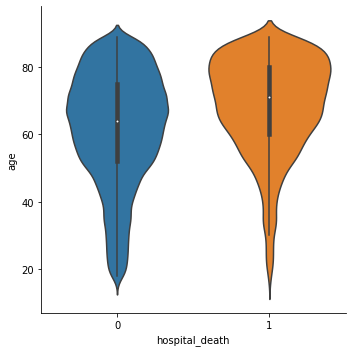

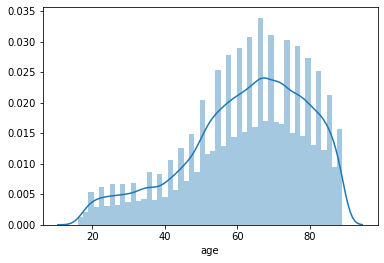

hospital_death,0,1
age,,
"(15.927, 23.3]",2204,67
"(23.3, 30.6]",2896,85
"(30.6, 37.9]",3387,151
"(37.9, 45.2]",5091,223
"(45.2, 52.5]",7582,420
"(52.5, 59.8]",11055,769
"(59.8, 67.1]",14619,1325
"(67.1, 74.4]",12925,1339
"(74.4, 81.7]",11238,1432


In [0]:
variable = "age"

sns.catplot(x="hospital_death", y=variable, kind="violin", data=df)
plt.show()
sns.distplot(df[variable])
plt.show()
pd.crosstab(pd.cut(df[variable],10),df.hospital_death)

## Gerando predições pro kaggle

In [0]:
# O scikit gera duas colunas, uma para a classe 0 e outra para a classe um
segunda_pipeline.classes_

# Queremos os scores da classe 1 (a probabilidade do paciente morrer)
df_kaggle_predicoes = pd.read_csv("https://raw.githubusercontent.com/widsrecife/dados/master/datathon2020/unlabeled.csv")

predicoes_kaggle_scores = segunda_pipeline.predict_proba(df_kaggle_predicoes)[:, 1]

# No kaggle os dados precisam de duas colunas: encounter_id e hospital_death
predicoes_kaggle_imput = pd.DataFrame(predicoes_kaggle_scores)
predicoes_kaggle_imput["encounter_id"] = df_kaggle_predicoes["encounter_id"] #pegamos os valores do dataset completo
predicoes_kaggle_imput.columns = ["hospital_death","encounter_id"] # renomeando as colunas
predicoes_kaggle_imput[["encounter_id","hospital_death"]].to_csv("catboost_baseline.csv",index=False)

# Feature engineering

In [0]:
def generate_new_diff_features(X):
    new_features = []

    columns_first_hour_sorted = sorted(columns_first_hour)
    scaler = MinMaxScaler()
    for col_1,col_2 in zip(columns_first_hour[0::2], columns_first_hour[1::2]):
        col_1_trim = col_1[:-4]
        col_2_trim = col_2[:-4]
        if col_1_trim == col_2_trim:
            X[col_1_trim+"_diff"] = X[col_2] - X[col_1]
            X[col_1_trim+"_diff"] = X[col_1_trim+"_diff"].apply(lambda x: abs(x))
            new_features.append(col_1_trim+"_diff")

    columns_first_day_sorted = sorted(columns_first_day)
    scaler = MinMaxScaler()
    for col_1,col_2 in zip(columns_first_day[0::2], columns_first_day[1::2]):
        col_1_trim = col_1[:-4]
        col_2_trim = col_2[:-4]
        if col_1_trim == col_2_trim:
            X[col_1_trim+"_diff"] = X[col_2] - X[col_1]
            X[col_1_trim+"_diff"] = X[col_1_trim+"_diff"].apply(lambda x: abs(x))
            new_features.append(col_1_trim+"_diff")

    return X

In [0]:
# Criando os steps

# 1. selecionar as colunas que vamos utilizar
def selecionar_colunas_new_features(X):
    return X.loc[:,continuous_features+categorical_features]

step_1 = FunctionTransformer(selecionar_colunas_new_features, validate=False)

# 2. gerar novas features pela diferença
step_2 = FunctionTransformer(generate_new_diff_features, validate=False)

# 3. preencher valores faltantes
step_3 = SimpleImputer(strategy="most_frequent")

# 4. treinar o modelo
step_4 = CatBoostClassifier(custom_loss=["AUC"],cat_features=categorical_features_indices,random_seed=43)

# Montando a pipeline
terceira_pipeline = Pipeline([("selecionar_colunas", step_1),
                              ("gerar_novas_features", step_2),
                              ("preencher_valores_faltantes", step_3),
                              ("modelo", step_4)])

In [0]:
terceira_pipeline.fit(X,y)

Learning rate set to 0.07094
0:	learn: 0.6035907	total: 335ms	remaining: 5m 34s
1:	learn: 0.5365940	total: 661ms	remaining: 5m 29s
2:	learn: 0.4796521	total: 958ms	remaining: 5m 18s
3:	learn: 0.4311019	total: 1.26s	remaining: 5m 14s
4:	learn: 0.3925975	total: 1.57s	remaining: 5m 12s
5:	learn: 0.3630985	total: 1.89s	remaining: 5m 13s
6:	learn: 0.3397927	total: 2.21s	remaining: 5m 12s
7:	learn: 0.3176838	total: 2.52s	remaining: 5m 12s
8:	learn: 0.3013000	total: 2.83s	remaining: 5m 11s
9:	learn: 0.2885486	total: 3.12s	remaining: 5m 8s
10:	learn: 0.2750555	total: 3.43s	remaining: 5m 8s
11:	learn: 0.2649285	total: 3.73s	remaining: 5m 6s
12:	learn: 0.2558415	total: 4.06s	remaining: 5m 8s
13:	learn: 0.2498452	total: 4.38s	remaining: 5m 8s
14:	learn: 0.2430429	total: 4.68s	remaining: 5m 7s
15:	learn: 0.2383401	total: 4.98s	remaining: 5m 6s
16:	learn: 0.2346839	total: 5.28s	remaining: 5m 5s
17:	learn: 0.2305727	total: 5.59s	remaining: 5m 5s
18:	learn: 0.2266201	total: 5.92s	remaining: 5m 5s
19:

Pipeline(memory=None,
         steps=[('selecionar_colunas',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function selecionar_colunas_new_features at 0x7fe271c7b730>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('gerar_novas_features',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function generate_new_diff_features at 0x7fe261969510>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('preencher_valores_faltantes',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
    

## Gerando dados para mandar para a competição no Kaggle

In [0]:
# O scikit gera duas colunas, uma para a classe 0 e outra para a classe um
terceira_pipeline.classes_

# Queremos os scores da classe 1 (a probabilidade do paciente morrer)
df_kaggle_predicoes = pd.read_csv("https://raw.githubusercontent.com/widsrecife/dados/master/datathon2020/unlabeled.csv")

predicoes_kaggle_scores = terceira_pipeline.predict_proba(df_kaggle_predicoes)[:, 1]

# No kaggle os dados precisam de duas colunas: encounter_id e hospital_death
predicoes_kaggle_imput = pd.DataFrame(predicoes_kaggle_scores)
predicoes_kaggle_imput["encounter_id"] = df_kaggle_predicoes["encounter_id"] #pegamos os valores do dataset completo
predicoes_kaggle_imput.columns = ["hospital_death","encounter_id"] # renomeando as colunas
predicoes_kaggle_imput[["encounter_id","hospital_death"]].to_csv("catboost_baseline_new_diff_features.csv",index=False)

## Cross-validation

In [0]:
cv_results = cross_validate(segunda_pipeline, X, y, 
                            cv=group_kfold, 
                            groups=group_ids, 
                            scoring="roc_auc",
                            return_estimator=True)

In [0]:
cv_results['test_score']